## Introduction

<h6>Face Recognition:</h6> 
 - Many classes, but very few examples for each class.

## Topics

- Face Recognition
- Siamese Network
- Triplet loss and Contrastive loss
- Defining and implementing our Dataset class.

## Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

D:\Projects\Conda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper methods

In [2]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

## Data

Here, we will use [Cambridge AT&T Face Dataset](https://www.kaggle.com/kasikrit/att-database-of-faces).
- It contains images from 40 different persons.
- For each person, there are 10 different images.

<img src='imgs/ATT_Face_Dataset-4rows.png' width='80%'/>

In [4]:
DATA_DIR = 'dataset/'
train_dir = f'{DATA_DIR}train'
valid_dir = f'{DATA_DIR}valid'

sz = 96
batch_size = 16
embed_size = 128
num_epochs = 10

cnn_name = 'resnet50'

In [5]:
# make validation dataset(tranfer 20% of data randomly to validation)
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='pgm')

### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:

In [6]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')   # convert('L')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [7]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),  # change the size with increase the zoom
    transforms.RandomCrop(sz),        # crop the with size
    transforms.RandomHorizontalFlip(), # flip 50% of images
    transforms.RandomRotation(5),  # rotate betwen 0-5 degree
    transforms.ToTensor()  # always return tensor
])

face_dataset = datasets.ImageFolder(train_dir) # face_dataset.imgs: give list of tuple contain img address and class label
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

#### Validation data

In [8]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

### Visualize dataset

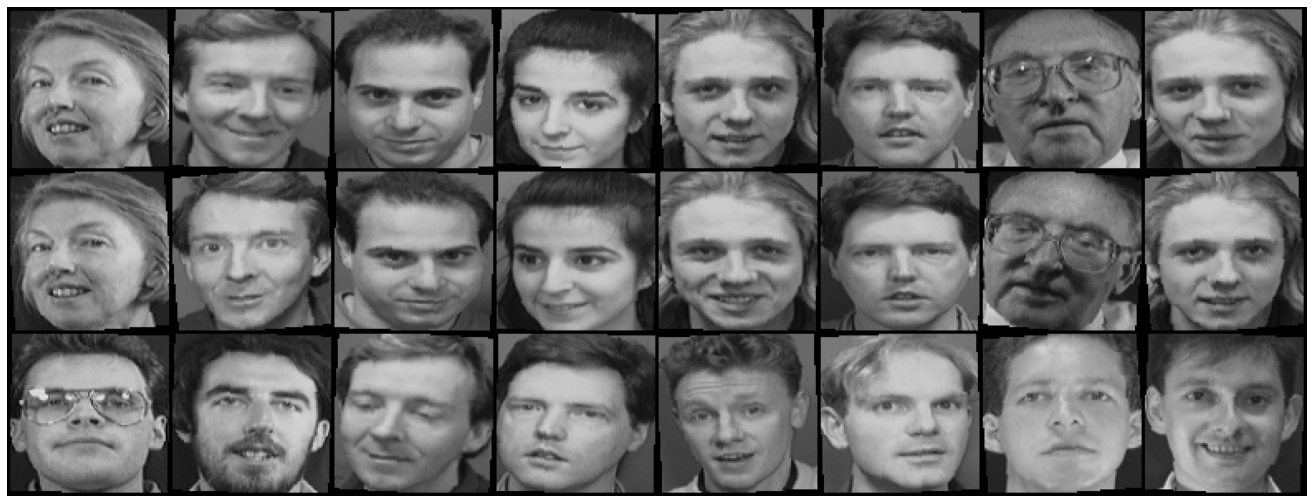

In [25]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs))
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat))

## Model: Triplet Netwok

In [9]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features     # in.features: number of weights after convolution layers
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),  # we can define each number, 512, 256 or 128 
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))   # last linear layer
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## Loss: Triplet Loss
Given a triplet $(a, p, n)$, the loss is defined as following:

$$L(a, p, n) = \max (\lVert f(a) - f(p) \rVert^2 - \lVert f(a) - f(n) \rVert^2 + \alpha, 0)$$

In wich:
- $a$ is the anchor image
- $p$ is the positive example, and
- $n$ is the negative example.

Also, $f(.)$ is the vector of features extracted from a CNN (i.e., embedding vector).

In [10]:
class TripletLoss(nn.Module): # when implement with nn.module it has a backward function and we do not need to implement our backward function

    def __init__(self, margin=0.2):   # margin is alpha
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)  # claculate euclidian distance for two vectors
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - \
                                     torch.pow(neg_distance, 2) + self.margin, min=0))   # clamp get max between x and 0
        return loss

## Train

In [11]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss = criterion(f_anc, f_pos, f_neg)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
        
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion, device):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    
    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

            f_anc, f_pos, f_neg = model(anc, pos, neg)
            loss = criterion(f_anc, f_pos, f_neg)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}\n--------')
        
        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()
            
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history

In [12]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)
 
# model
cnn = get_model(cnn_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# loss and optimizer
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

D:\Projects\Conda\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
D:\Projects\Conda\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [13]:
type(model)

__main__.TripletNetwork

In [33]:
model, best_weights, loss_hist = train(model, 
                                       train_dl, valid_dl, 
                                       criterion, optimizer, 
                                       device,
                                       scheduler, 
                                       num_epochs=num_epochs)

Epoch 1
--------
 Training Step [20/20]: loss 22.98759  
 Validation Step [ 5/ 5]: loss 8.85053   

Epoch 2
--------
 Training Step [20/20]: loss 11.26795  
 Validation Step [ 5/ 5]: loss 13.57294  

Epoch 3
--------
 Training Step [20/20]: loss 10.60293  
 Validation Step [ 5/ 5]: loss 1.05380  

Epoch 4
--------
 Training Step [20/20]: loss 7.37900   
 Validation Step [ 5/ 5]: loss 0.90410  

Epoch 5
--------
 Training Step [20/20]: loss 4.45101  
 Validation Step [ 5/ 5]: loss 2.84118  

Epoch 6
--------
 Training Step [20/20]: loss 8.41122   
 Validation Step [ 5/ 5]: loss 0.00000  

Epoch 7
--------
 Training Step [20/20]: loss 2.54742  
 Validation Step [ 5/ 5]: loss 0.00000  

Epoch 8
--------
 Training Step [20/20]: loss 2.12141  
 Validation Step [ 5/ 5]: loss 0.00000  

Epoch 9
--------
 Training Step [20/20]: loss 1.37837  
 Validation Step [ 5/ 5]: loss 0.81580  

Epoch 10
--------
 Training Step [20/20]: loss 1.93033   
 Validation Step [ 5/ 5]: loss 0.00000  



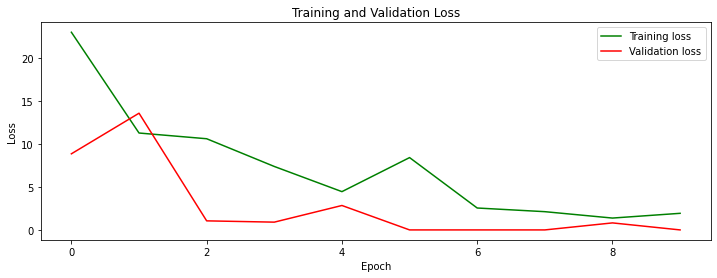

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

In [53]:
model.load_state_dict(torch.load('model/resnet50.pth'))
# torch.save(model.state_dict(), 'model/resnet50.pth')

<All keys matched successfully>

## Testing

In [54]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

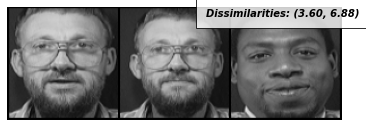

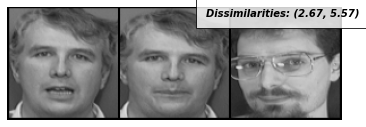

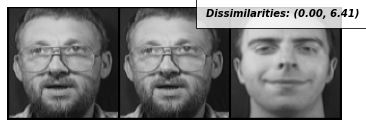

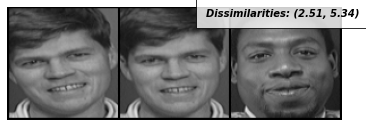

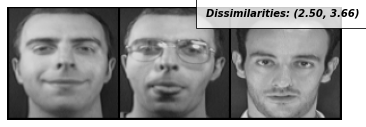

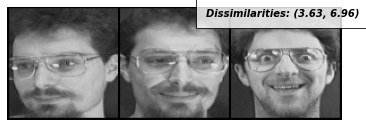

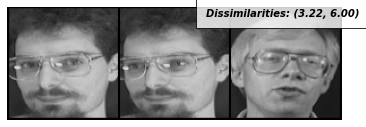

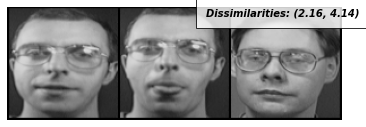

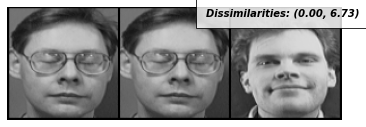

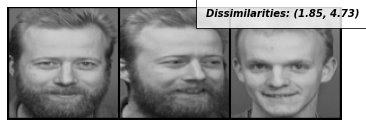

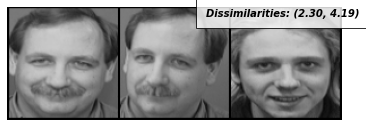

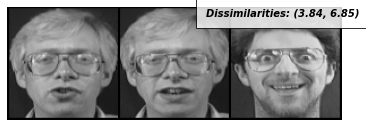

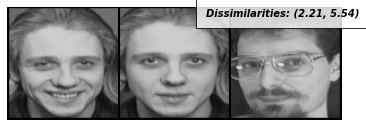

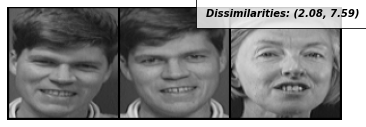

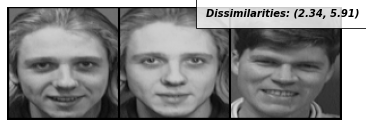

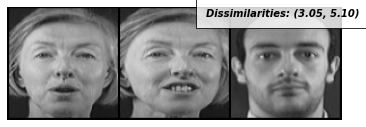

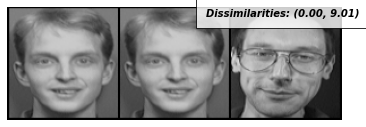

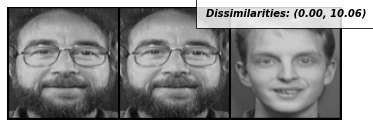

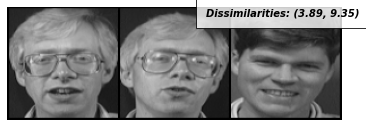

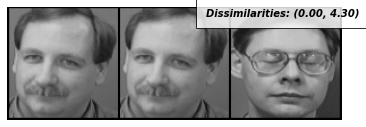

In [55]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')